In [1]:
# Common imports
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.ndimage.interpolation import shift

def sort_by_target(mnist):  #From Geron HoM Github
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [2]:
#Fetch the MNIST data
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) 
sort_by_target(mnist) 

mnist["data"],mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

(70000, 784)
(70000,)


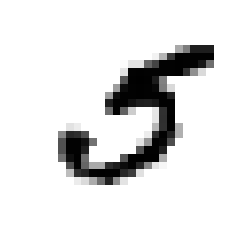

Displayed digit label: 5


In [3]:
###Data discovery
X,y = mnist["data"],mnist["target"]

print(X.shape)
print(y.shape)

#Random digit from mnist dataset displayed as well as its label
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

print('Displayed digit label:',y[36000])




In [4]:
###Data split and shuffle
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
###Training a Binary Classifier (for 5)
#Adapting data

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#Train SDGClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

#Classify image
sgd_clf.predict([some_digit])


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([ True])

In [6]:
###Peformance Measures

SGD_accuracy = cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

#Base estimator
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
never_5_accuracy = cross_val_score(never_5_clf,X_train,y_train_5,cv = 3,scoring = "accuracy")

print('sgd_clf vs never_5_clf\n',SGD_accuracy,"vs",never_5_accuracy)

c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

sgd_clf vs never_5_clf
 [0.95725 0.95165 0.9598 ] vs [0.90765 0.9101  0.9112 ]


In [7]:
##Confusion Matrix

#Acquire model preditions
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

confusion_matrix(y_train_5,y_train_pred)


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

array([[54287,   292],
       [ 2334,  3087]], dtype=int64)

In [8]:
## Precision, Recall and F1 score

prec = precision_score(y_train_5,y_train_pred)
recall = recall_score(y_train_5,y_train_pred)
f1 = f1_score(y_train_5,y_train_pred)

print("precision:",prec,"\n\nrecall:",recall,"\n\nF1 score:",f1)

precision: 0.9135839005622965 

recall: 0.5694521306032098 

F1 score: 0.701590909090909


In [9]:
##Precison/Recall Tradeoff

y_scores = sgd_clf.decision_function([some_digit])
print('Decision score for 5:',y_scores)

threshold = 200000 #set threshold
y_some_digit_pred = (y_scores > threshold)
print('Increased decision threshold prediction results:',y_some_digit_pred,'\n\nthus, the decision threshold reduces recall and thus results in the model misclassifying the 5')


Decision score for 5: [43554.94604397]
Increased decision threshold prediction results: [False] 

thus, the decision threshold reduces recall and thus results in the model misclassifying the 5


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

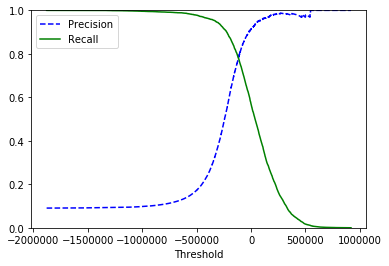

In [10]:
##Precision Recall Curves

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

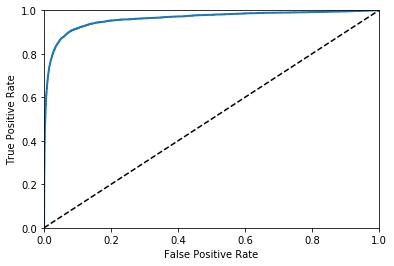

0.9616149420501401


In [11]:
##Roc Curve

fpr,tpr,threshold = roc_curve(y_train_5,y_scores)

plot_roc_curve(fpr,tpr)
plt.show()

#Area Under Curve (ROC)
print(roc_auc_score(y_train_5,y_scores))


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upp

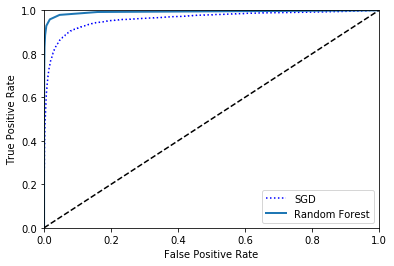

In [12]:
##Random Forest Classification model implementation

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [13]:
###Multiclass Classification

#OvO multiclass classification
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([5], dtype=int8)

In [14]:
##Random Forest multiclass classification

forest_clf.fit(X_train,y_train)
Forest_prediction_5 = forest_clf.predict([some_digit])

Forest_classification_proba = forest_clf.predict_proba([some_digit])

print('RF Prediction:',Forest_prediction_5)
print('RF Classification Probabilities:',Forest_classification_proba)

c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF Prediction: [5]
RF Classification Probabilities: [[0.1 0.  0.  0.  0.  0.8 0.  0.1 0.  0. ]]


In [15]:
##Classifier evaluation

SGD_accuracy = cross_val_score(sgd_clf,X_train,y_train, cv= 3,scoring = "accuracy")
print('SGD Classifier Accuracy:',SGD_accuracy)


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

SGD Classifier Accuracy: [0.84623075 0.85554278 0.85107766]


In [16]:
##implemente standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
SGD_accuracy_SS = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print('SGD Classifier Accuracy with Standard Scaler:',SGD_accuracy_SS)

c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

SGD Classifier Accuracy with Standard Scaler: [0.91166767 0.90899545 0.90758614]


In [17]:
##Error Analysis

y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
print(conf_mx)


c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters h

[[5728    3   21   11   10   50   49    9   38    4]
 [   1 6469   47   27    6   46    9   10  116   11]
 [  57   34 5337   94   74   24   95   59  171   13]
 [  58   36  135 5325    2  250   36   51  138  100]
 [  18   26   47   10 5327   11   62   29   83  229]
 [  72   41   32  176   68 4643  109   29  162   89]
 [  34   24   46    2   44   96 5625    4   43    0]
 [  25   24   65   29   51   13    7 5797   17  237]
 [  57  151   73  153   14  162   56   25 5023  137]
 [  51   27   24   87  163   33    3  199   71 5291]]


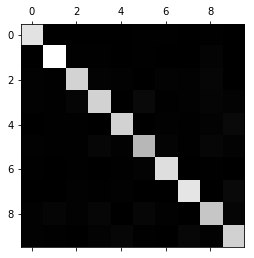

In [18]:
#Visual Conf Mx
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

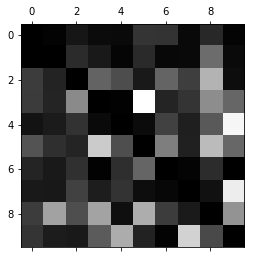

In [19]:
#Find and highlight errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [20]:
#multilabel classification

#create new labels
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

#Implement KNN Classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [21]:
#Multilabel Evaluation

#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=2)
#f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
###Exercises
#1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
#on the test set. Hint: the KNeighborsClassifier works quite well for this task;
#you just need to find good hyperparameter values (try a grid search on the
#weights and n_neighbors hyperparameters).

In [ ]:

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [2, 4, 6]}]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf,param_grid,cv=3,verbose=10,n_jobs=-1)

grid_search.fit(X_train,y_train)


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

In [22]:
#2. Write a function that can shift an MNIST image in any direction (left, right, up,
#or down) by one pixel.Then, for each image in the training set, create four shifted
#copies (one per direction) and add them to the training set. Finally, train your
#best model on this expanded training set and measure its accuracy on the test set.
#You should observe that your model performs even better now! This technique of 
#artificially growing the training set is called data augmentation or training set
#expansion.

In [26]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = image
y_train_augmented = label

#X_train_augmented = np.array(X_train_augmented)
#y_train_augmented = np.array(y_train_augmented)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
print(X_train_augmented)
print(y_train_augmented)